## Finding the optimal window size for modular exponentiation

In this notebook we find optimal window size for modular exponentiation algorithm described in [this paper](https://arxiv.org/abs/2112.11358), experimentally and theoretically.

Complexity of windowed modular exponentiation is 

$$T(n, m)=(c_1 \cdot 2^m + c_2 \cdot n^2) \cdot \frac{n}{m} = c_1 \cdot 2^m \cdot \frac{n}{m} + c_2 \cdot \frac{n^3}{m}.$$

We can fit values $c_1$ and $c_2$ to the experimental data using least squares. Let's use $m=5 \dots 15$, $n = 2m \dots 3m$.

In [1]:
import qsharp
import json
from diskcache import Cache
import re_utils

re_utils.DEBUG = True

cache = Cache("~/quant-arith-cache/re-mod-exp")
qsharp.init(project_root="../lib/")

@cache.memoize()
def estimate_resources_mod_exp(op, n):
    est = qsharp.estimate(f"EstimateUtils.RunModExp({n},{op})")
    return json.dumps(est)    

In [2]:
import numpy as np    
from matplotlib import pyplot as plt

def T_experiment(n,m):
    op = f"QuantumArithmetic.LYY2021.ModExpWindowedMontgomery(_,_,_,_,{m})"
    est = json.loads(estimate_resources_mod_exp(op,n))
    return est['physicalCounts']['runtime']/10**9
        
X = []
Y=[]
for m in range(5, 16):
    for n in range(2*m, 3*m+1):
        X.append([2**m * (n/m), n**3/m])
        Y.append(T_experiment(n,m))
        
(c1,c2), _, _, _ = np.linalg.lstsq(X, Y, rcond=None)
print(f"c1={c1:.5e}, c2={c2:.5e}")


c1=6.26437e-05, c2=1.01564e-03


Let's verify this prediction.

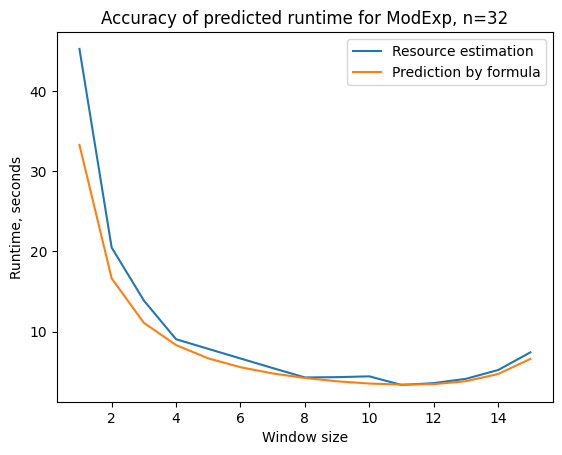

In [3]:
def T_prediction(n,m):
    return (c1*2**m +c2*n**2)*(n/m)

n=32
T_exp, T_pred=[], []
m_range = list(range(1,16))
for m in m_range:
    T_exp.append(T_experiment(n,m))
    T_pred.append(T_prediction(n,m))
    
plt.plot(m_range, T_exp, label='Resource estimation')
plt.plot(m_range, T_pred, label='Prediction by formula')
plt.legend()
plt.xlabel("Window size")
plt.ylabel("Runtime, seconds")
plt.title(f"Accuracy of predicted runtime for ModExp, n={n}")
plt.show()

Now, we can use the approximate formula for $T$ to find optimal window size for given n. We could use condition $\frac{\partial T}{\partial m}= 0$ and get explicit formula, but it's easier to just numerically optimize it.    

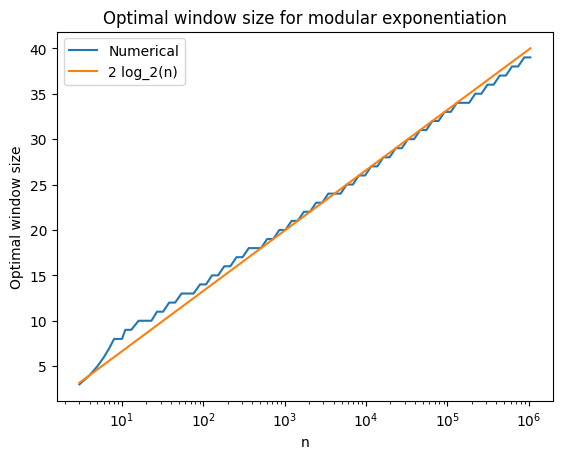

Max error 2.081


In [4]:
def get_optimal_window_size(n):
    return 1+np.argmin([T_prediction(n,m) for m in range(1,min(300,n+1))])

n_range = re_utils.DEFAULT_N_RANGE
plt.plot(n_range, [get_optimal_window_size(i) for i in n_range], label='Numerical')
plt.plot(n_range, 2*np.log2(n_range), label='2 log_2(n)')
plt.xscale('log')
plt.xlabel('n')
plt.ylabel('Optimal window size')
plt.title('Optimal window size for modular exponentiation')
plt.legend()
plt.show()

print("Max error %.03f" % max([np.abs(get_optimal_window_size(n)-(2*np.log2(n))) for n in n_range]))

As we see, the optimal value is very close to $2 \log_2(n).$

We could get this theoretically as well:

$$\frac{\partial T}{\partial m} = \frac{c_1 \cdot 2^m  \cdot n  (m \cdot \log(2)-1)-c_2 \cdot n^3}{m^2} =0$$

$$c_1 \cdot 2^m \cdot n \cdot ( m \cdot \log(2) -1 ) - c_2 n^3  =0$$

$$ 2^m \cdot ( m \cdot \log(2) -1 ) = \frac{c_2}{c_1} n^2  =0$$

Take $\log_2$ of both parts:

$$m + \log_2(m \cdot \log(2) -1) = \log_2{(c_2/c_1)} + 2 \log_2(n). $$

From the fitted data, $\log_2{(c_2/c_1)} \approx 4.02$. For $m \in [2, 40]$, $\log_2(m \cdot \log(2) -1) \in [-1.37, 4.70]$. So, approximately, $m^* \approx 2 \log_2(n)$.